# DeepFM Hotel Reco (Content Based)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import seaborn as sns
import math
import sys
from math import sqrt

from tensorflow.keras.layers import *
from keras import backend as K
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score

from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/zulfauzi92/Hotel_Recomendation_Model_Traveloka/main/Eksplorasi%20Data/Main%20Dataset/csv_final/Final_Dataset_Hotel_ML.csv'
hotel_train_data = pd.read_csv(url)

In [ ]:
hotel_train_data.head(2)

,Unnamed: 0,hotel_id,total_review,latitude,longitude,hotel_star_rating,site_review_rating,Beach Hut,BnB,Bungalow,...,Heating Facility on Request,Safe,Iron / Ironing board,Microwave / Oven,Window Open / Ventilation,Outdoor Parking,Porter Services,Spa Services,Poolside Cafe,Airport Transfer
0,0,H000001,8,35.9,-78.8,2,4.2,0,0,0,...,1,1,0,0,1,0,1,0,0,0
1,1,H000002,3,28.5,-81.5,0,5.0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# Data Pre-processing

In [ ]:
hotel_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Columns: 277 entries, Unnamed: 0 to Airport Transfer
dtypes: float64(3), int64(273), object(1)
memory usage: 2.8+ MB


In [ ]:
df = hotel_train_data
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
df.columns = df.columns.str.replace('/', '')

In [ ]:
df.columns = df.columns.str.replace('(', '')

In [ ]:
df.columns = df.columns.str.replace(')', '')

In [ ]:
df.columns = df.columns.str.replace("'", "_")

In [ ]:
df.columns = df.columns.str.replace(",", "_")

In [ ]:
df.columns = df.columns.str.replace("&", "-")

In [ ]:
df.columns = df.columns.str.replace("-amp;", "-")

In [ ]:
df.head(3)

,Unnamed:_0,hotel_id,total_review,latitude,longitude,hotel_star_rating,site_review_rating,Beach_Hut,BnB,Bungalow,...,Heating_Facility_on_Request,Safe,Iron__Ironing_board,Microwave__Oven,Window_Open__Ventilation,Outdoor_Parking,Porter_Services,Spa_Services,Poolside_Cafe,Airport_Transfer
0,0,H000001,8,35.9,-78.8,2,4.2,0,0,0,...,1,1,0,0,1,0,1,0,0,0
1,1,H000002,3,28.5,-81.5,0,5.0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,2,H000003,2,40.3,-80.0,2,5.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
print(df.columns.tolist())

['Unnamed:_0', 'hotel_id', 'total_review', 'latitude', 'longitude', 'hotel_star_rating', 'site_review_rating', 'Beach_Hut', 'BnB', 'Bungalow', 'Cottage', 'Farm_Stay', 'Guest_House', 'Homestay', 'Hostel', 'Hotel', 'Houseboat', 'Lodge', 'Motel', 'Palace', 'Resort', 'Service_Apartment', 'Tent', 'Villa', '_Bike_on_Rent', '_Drivers_Rest_Room', 'ATM__Banking', 'Access_Via_Exterior_Corridors', 'Adjoining_Rooms', 'Air__Rail_Booking', 'Air-Conditioning_-_Central', 'Amphitheatre', 'Ayurvedic_Facilities_', 'Babysitting_Child_Care_surcharge', 'Badminttion_Court', 'Baggage_Room', 'Ballroom', 'Banquet_Facilities', 'Bar__Lounge_', 'Barbecue_Area', 'Basketball_Court_', 'Beauty_Salon_-_on_charge', 'Billiards', 'Board_Room', 'Bowling', 'Business_Center', 'CCTV', 'Campfire__Bon_Fire', 'Car_Rental', 'Casino', 'Catering', 'Cell_Phone_Rental', 'Children_s_Park', 'City_Shuttle_Service', 'Clubhouse', 'Coffee_Shop__Cafe', 'Computer_Rental', 'Concierge', 'Conference_Facility', 'Courier_Service', 'Currency_Excha

We categorize the features and isolate 'em

In [ ]:
sparse_features = ['Beach_Hut', 'BnB', 'Bungalow', 'Cottage', 'Farm_Stay', 'Guest_House', 'Homestay', 'Hostel', 'Hotel', 'Houseboat', 'Lodge', 'Motel', 'Palace', 'Resort', 'Service_Apartment', 'Tent', 'Villa', '_Bike_on_Rent', '_Drivers_Rest_Room', 'ATM__Banking', 'Access_Via_Exterior_Corridors', 'Adjoining_Rooms', 'Air__Rail_Booking', 'Air-Conditioning_-_Central', 'Amphitheatre', 'Ayurvedic_Facilities_', 'Babysitting_Child_Care_surcharge', 'Badminttion_Court', 'Baggage_Room', 'Ballroom', 'Banquet_Facilities', 'Bar__Lounge_', 'Barbecue_Area', 'Basketball_Court_', 'Beauty_Salon_-_on_charge', 'Billiards', 'Board_Room', 'Bowling', 'Business_Center', 'CCTV', 'Campfire__Bon_Fire', 'Car_Rental', 'Casino', 'Catering', 'Cell_Phone_Rental', 'Children_s_Park', 'City_Shuttle_Service', 'Clubhouse', 'Coffee_Shop__Cafe', 'Computer_Rental', 'Concierge', 'Conference_Facility', 'Courier_Service', 'Currency_Exchange', 'Disabled_Friendly_Facilities_', 'Disabled_Friendly_Rooms', 'Discotheque_', 'Doctor_on_Call', 'Doorman', 'Dry_Cleaning', 'Electronic__Magnetic_Keys', 'Electronic_Check-Out', 'Exhibit_Space', 'Express_Check-In__Check-Out', 'Express_Laundry', 'Extra_Person__Child_-_Share_the_same_room', 'Family_Room', 'Fax_Machine', 'Fire_Place_Available_', 'Fire_Safety', 'First-Aid_Kit_at_Front_Desk', 'Fishing', 'Fitness_Equipment', 'Floor_Butler', 'Flower_Shop', 'Free_Local_Calls', 'Front_Desk', 'Full_Time_Operation_for_All_7_Days', 'Fun_Floats', 'Games_Zone', 'Gardens', 'Gift_Shop_', 'Golf_Course', 'Grocery', 'Guide__Sightseeing_Service', 'Health_Club__Gym_Facility_Available', 'Hookah_Lounge', 'In_House_Events_', 'Internet_Access_-_Surcharge', 'Jacuzzi', 'Karaoke', 'Kids_Play_Zone', 'Laundry_Service_Available', 'Library', 'Lift__Elevator', 'Limousine_Service_Available', 'Lobby', 'Local_Tour__Travel_Desk', 'Locker_Facility', 'Major_Credit_Cards_Accepted', 'Marina_On_Site', 'Massage_Services', 'Medical_Assistance_Available', 'Metal_Detectors', 'Mini_Theatre', 'Multi_Cuisine_Restaurant', 'Multi_Lingual_Staff', 'Nature_Walk', 'Night_Club', 'Open_Air_Restaurant__Dining', 'Oxygen_Cylinder_on_request', 'Paid_Transfers', 'Parking_Facility', 'Party_hall', 'Pest_Control_Facility', 'Pets_Allowed', 'Pick_Up_and_Drop_Rly_Station__Bus_Stand__Temple', 'Picnic_Area', 'Pool_Table', 'Postal__Parcel_Services', 'Power_Backup', 'Private__Plunge_Pool', 'Private_Beach', 'Public_Restrooms', 'RO_Water_Purification_System', 'Recreation_Zone', 'Restaurant', 'Rooftop_Garden', 'Sauna', 'Secretarial_Services', 'Security_at_All_Hotel_Entrances', 'Self_Check_-_In', 'Separate_Sitting_Area', 'Skiing_Facility_Available', 'Smoke_Detector', 'Smoking_Area', 'Solarium', 'Speciality_Restaurant', 'Squash_court', 'Stamps_and_Mailing_Facility', 'Suites', 'Swimming_Pool', 'Table_Tennis', 'Taxi_Services', 'Tennis_Court', 'Valet_service', 'Vegetarian_Food__Jain_Food_Available', 'Veranda', 'Virtual_Golf', 'Voicemail', 'Wake-up_Call__Service', 'Water_Dispenser_Available', 'Wedding_Services_Facility', 'Welcome_Drinks', 'Wheelchair_Accessibility_-_Room', 'Whirlpool_Bath__Shower_Cubicle', 'X-Ray_Machine_at_Entrance', '120_AC', '220_AC', 'Air_Conditioning', 'Air_Cooler', 'Alarm_Clock', 'Attached_Bathroom', 'Balcony', 'Bathrobe', 'Bathrobes', 'Bathroom_Amenities', 'Bathtub', 'Bathtub_Only', 'Bedside_Table', 'Bidet', 'Blackout_Drapes', 'Breakfast_Available', 'Breakfast_chargeable', 'Ceiling_Fan', 'Centrally_Heated', 'Channel_Music', 'Climate_Control', 'Closet', 'Clothes_Dryer', 'Clothes_Hook_in_Bathroom', 'Coffee_Table', 'Complete_Bedding', 'Complimentary_Use_of_Bicycle', 'Computer', 'Cribs_Available', 'Crockery__Cutlery', 'CurtainsShades', 'Daily_Room_Cleaning', 'Desk', 'Direct_Dial_Phone', 'Disabled_Friendly_Bathrooms', 'Do-Not-Disturb_Notice', 'Dressing_Area', 'Dustbins', 'Ensuite__Private_Bathroom', 'Extra_Bed__Towels__Linens__Bedding_on_request', 'Extra_Toilteries_on_Demand', 'Full_Kitchen', 'Gas_Cylinder_-_Chargeable', 'HD__LCD_Satellite_TV', 'Hairdryer', 'Handicapped_Facilities', 'Hill_View_from_all_Rooms', 'Hot__Cold_Running_Water', 'Housekeeping', 'Ice_Bucket_on_Demand', 'In-room_Storage_Space', 'Induction_Plate', 'International_Switch_Plugs_on_request', 'Kitchenette', 'Luggage_Rack', 'Mineral_Water', 'Mini_Bar', 'Mini_Refrigerator', 'Mirror', 'Modern_Toilet_Facilities', 'Movie_Channels', 'Movies_-_Games_on_demand', 'Newspapers', 'No_Smoking_Room', 'Patio_-_Property', 'Phone_Messaging_Services', 'Pillow_menu', 'Premium_Amenities__Toiletries', 'Premium_Beddings__Hypo-Allergenic_', 'Primium_Bathrooms', 'Private_Garden', 'Radio', 'Reading_Lamps', 'Remote_Control_TV', 'Remote_Controlled_Lights_and_Fan', 'Rollaway_Beds', 'Room_Door_Fitted_with_Lock_and_Key', 'Safe_on_request', 'Sanitary_Bin', 'Second_Bathrooms', 'Separate_Bathtubs_And_Shower', 'Shared_Bathroom', 'Shower', 'Shower_Cap', 'Slippers', 'Snacks__Beverage', 'Sofa_Cum_Bed_Available', 'Sofa_Table__Extra_Seats', 'Soft_Bar', 'Soundproof_Windows', 'Split_A.C_s', 'Studio_Apartment_-_Large', 'Tea_Coffee_Kettle__Maker', 'Telephone', 'Television', 'Toaster', 'Toiletries', 'Utensils_on_request', 'Video_DVD_CD_Player_Available', 'Wardrobe', 'Washing_machine', 'Western_Toilet_Seat', 'Work_Station', 'Heating_Facility_on_Request', 'Safe', 'Iron__Ironing_board', 'Microwave__Oven', 'Window_Open__Ventilation', 'Outdoor_Parking', 'Porter_Services', 'Spa_Services', 'Poolside_Cafe', 'Airport_Transfer']

In [ ]:
dense_features = ['latitude', 'longitude']

In [ ]:
df['id_hotel_num_only'] = df['hotel_id'].map(lambda x: x.lstrip('H'))
df['id_hotel_num_only'] = df['id_hotel_num_only'].astype(int)

In [ ]:
df['label'] = df['item']

In [ ]:
target = ['site_review_rating']

Generate feature columns

In [ ]:
# Label Encoding for sparse features,and normalization for dense numerical features
for feat in sparse_features:
        lbe = LabelEncoder()
        df[feat] = lbe.fit_transform(df[feat])
mms = MinMaxScaler(feature_range=(0, 1))
df[dense_features] = mms.fit_transform(df[dense_features])

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=df[feat].nunique(),embedding_dim=4)
                          for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                          for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [ ]:
dnn_feature_columns

[SparseFeat(name='Beach_Hut', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fc7e5667b90>, embedding_name='Beach_Hut', group_name='default_group', trainable=True),
 SparseFeat(name='BnB', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fc7e5667a90>, embedding_name='BnB', group_name='default_group', trainable=True),
 SparseFeat(name='Bungalow', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fc7e56c4410>, embedding_name='Bungalow', group_name='default_group', trainable=True),
 SparseFeat(name='Cottage', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabul

In [ ]:
linear_feature_columns

[SparseFeat(name='Beach_Hut', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fc7e5667b90>, embedding_name='Beach_Hut', group_name='default_group', trainable=True),
 SparseFeat(name='BnB', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fc7e5667a90>, embedding_name='BnB', group_name='default_group', trainable=True),
 SparseFeat(name='Bungalow', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fc7e56c4410>, embedding_name='Bungalow', group_name='default_group', trainable=True),
 SparseFeat(name='Cottage', vocabulary_size=2, embedding_dim=4, use_hash=False, vocabul

In [ ]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'])

# Building the Neural Network

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Beach_Hut (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
BnB (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Bungalow (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cottage (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
train, test = train_test_split(df, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [ ]:
train_model_input

{'120_AC': array([0, 0, 0, ..., 0, 0, 0]),
 '220_AC': array([0, 0, 0, ..., 0, 0, 0]),
 'ATM__Banking': array([0, 0, 0, ..., 0, 0, 0]),
 'Access_Via_Exterior_Corridors': array([0, 0, 0, ..., 0, 0, 0]),
 'Adjoining_Rooms': array([0, 0, 1, ..., 0, 0, 0]),
 'Air-Conditioning_-_Central': array([0, 0, 0, ..., 0, 1, 1]),
 'Air_Conditioning': array([1, 1, 1, ..., 1, 1, 1]),
 'Air_Cooler': array([0, 0, 0, ..., 0, 0, 0]),
 'Air__Rail_Booking': array([0, 0, 1, ..., 1, 0, 0]),
 'Airport_Transfer': array([0, 0, 0, ..., 1, 0, 0]),
 'Alarm_Clock': array([0, 1, 0, ..., 0, 0, 1]),
 'Amphitheatre': array([0, 0, 0, ..., 0, 0, 0]),
 'Attached_Bathroom': array([0, 0, 1, ..., 1, 0, 1]),
 'Ayurvedic_Facilities_': array([0, 0, 0, ..., 0, 1, 0]),
 'Babysitting_Child_Care_surcharge': array([0, 0, 1, ..., 0, 0, 0]),
 'Badminttion_Court': array([0, 0, 0, ..., 0, 1, 0]),
 'Baggage_Room': array([0, 0, 1, ..., 1, 1, 1]),
 'Balcony': array([1, 0, 1, ..., 0, 0, 0]),
 'Ballroom': array([0, 0, 0, ..., 0, 0, 0]),
 'Banqu

In [ ]:
test_model_input

{'120_AC': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '220_AC': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0,

In [ ]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
27/27 [==============================] - 63s 343ms/step - loss: -29.6831 - binary_crossentropy: -29.6831 - val_loss: -45.6969 - val_binary_crossentropy: -45.6969
Epoch 2/15
27/27 [==============================] - 1s 51ms/step - loss: -45.4202 - binary_crossentropy: -45.4202 - val_loss: -45.6969 - val_binary_crossentropy: -45.6969
Epoch 3/15
27/27 [==============================] - 1s 52ms/step - loss: -45.4202 - binary_crossentropy: -45.4202 - val_loss: -45.6969 - val_binary_crossentropy: -45.6969
Epoch 4/15
27/27 [==============================] - 1s 54ms/step - loss: -45.4202 - binary_crossentropy: -45.4202 - val_loss: -45.6969 - val_binary_crossentropy: -45.6969
Epoch 5/15
27/27 [==============================] - 1s 51ms/step - loss: -45.4202 - binary_crossentropy: -45.4202 - val_loss: -45.6969 - val_binary_crossentropy: -45.6969
Epoch 6/15
27/27 [==============================] - 1s 52ms/step - loss: -45.4202 - binary_crossentropy: -45.4202 - val_loss: -45.6969 - val_bi

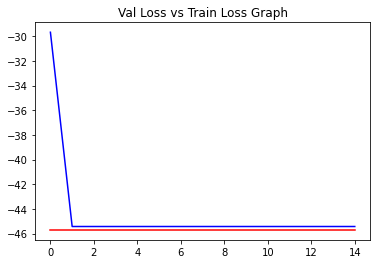

In [ ]:
# summarize history for loss
plt.plot(history.history['val_loss'], color='r', label='Val Loss')
plt.plot(history.history['loss'], color='b', label='Train Loss')
plt.title('Val Loss vs Train Loss Graph')
plt.show()

# Hyperparams Tuning

In [ ]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4)
            ,  l2_reg_linear=1e-06, l2_reg_embedding=0.001,seed=1024, dnn_dropout=0.7, dnn_activation='relu',task='binary',
               fm_group=['default_group'],l2_reg_dnn=1e-06, dnn_use_bn=False)

In [ ]:
model.compile('adam', loss="mae", metrics=['accuracy'])

In [ ]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=32, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
27/27 [==============================] - 56s 332ms/step - loss: 3.0286 - accuracy: 0.0489 - val_loss: 2.9969 - val_accuracy: 0.0190
Epoch 2/20
27/27 [==============================] - 1s 47ms/step - loss: 2.9788 - accuracy: 0.0489 - val_loss: 2.9970 - val_accuracy: 0.0190
Epoch 3/20
27/27 [==============================] - 1s 47ms/step - loss: 2.9788 - accuracy: 0.0489 - val_loss: 2.9970 - val_accuracy: 0.0190
Epoch 4/20
27/27 [==============================] - 1s 48ms/step - loss: 2.9788 - accuracy: 0.0489 - val_loss: 2.9969 - val_accuracy: 0.0190
Epoch 5/20
27/27 [==============================] - 1s 50ms/step - loss: 2.9788 - accuracy: 0.0489 - val_loss: 2.9969 - val_accuracy: 0.0190
Epoch 6/20
27/27 [==============================] - 1s 47ms/step - loss: 2.9788 - accuracy: 0.0489 - val_loss: 2.9969 - val_accuracy: 0.0190
Epoch 7/20
27/27 [==============================] - 1s 49ms/step - loss: 2.9788 - accuracy: 0.0489 - val_loss: 2.9969 - val_accuracy: 0.0190
Epoch 8/20


In [ ]:
pred_result = model.predict(test_model_input, batch_size=32)
pred_result

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [ ]:
pred_result = np.array([a[0] for a in pred_result])

recommended_item_ids = (-pred_result).argsort()[:5]

recommended_item_ids

array([  0, 166, 167, 168, 169])

In [ ]:
rows = []
hotel = list(df.drop_duplicates(subset='id_hotel_num_only', keep='first').id_hotel_num_only)
names = list(df.drop_duplicates(subset='id_hotel_num_only', keep='first').id_hotel_num_only)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'id_hotel_num_only' : hotel[i], 'user_id' : 1}))
test_data = pd.DataFrame(rows)

In [ ]:
for idx, (score, name) in enumerate(sorted(zip(pred_result, names), reverse=True)):
    if idx >= 5:
        break
 
    print("Score: ", round(float(score), 2), " for hotel: ", name)

Score:  1.0  for hotel:  263
Score:  1.0  for hotel:  262
Score:  1.0  for hotel:  261
Score:  1.0  for hotel:  260
Score:  1.0  for hotel:  259
